In [33]:
import argparse
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from data import get_model_input
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
from model import get_best_model
from venn import venn, pseudovenn

In [34]:
config = get_config("configs/debug_med_LM.yml", "_curation")
all_feature_columns, target, train_model_input, test_model_input, feature_names, original_feature_map, max_voted_users, train_data, test_data = get_model_input(config)
model, user_embedding = get_best_model(config, all_feature_columns, feature_names)
active_user_votes_thres = config["active_user_votes_thres"]
train_data["UPVOTED_USERS"] = train_model_input["UPVOTED_USERS"]
train_data["DOWNVOTED_USERS"] = train_model_input["DOWNVOTED_USERS"]
test_data["UPVOTED_USERS"] = test_model_input["UPVOTED_USERS"]
test_data["DOWNVOTED_USERS"] = test_model_input["DOWNVOTED_USERS"]

GPU ready...
Smart using cuda:0
------------------ 2022-07-18 08:30:49 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/data.py:180 get_model_input
Loading prepared data...
------------------ 2022-07-18 08:30:49 ------------------


Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
def get_popular_subreddits(train_data, test_data, user_votes_thres = 0):
    subreddit_votes_counter = Counter()
    subreddit_active_users = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_active_users[row["SUBREDDIT"]][row["USERNAME"]] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
    for subreddit in subreddit_active_users:
        users_vote_count = subreddit_active_users[subreddit]
        subreddit_active_users[subreddit] = {user for user in users_vote_count if users_vote_count[user] >= user_votes_thres}
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]]:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions
subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions = get_popular_subreddits(train_data, test_data, user_votes_thres = active_user_votes_thres) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data
common_subreddits_counts = subreddit_votes_counter.most_common(20)
for subreddit_id, vote_counts in common_subreddits_counts:
    print(f"Subreddit {subreddit_id}: {original_feature_map['SUBREDDIT'][subreddit_id]}, {vote_counts} votes")
a_subreddit = int(input("Select a subreddit: ")) # common_subreddits_counts[0][0]
print_log(config["log_path"], f"Selected subreddit: {a_subreddit} ({original_feature_map['SUBREDDIT'][a_subreddit]})")
a_subreddit_active_users:set = subreddit_active_users[a_subreddit]
print_log(config["log_path"], f"In train data, subreddit {a_subreddit} have {len(a_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[a_subreddit]} votes and {len(subreddit_train_submissions[a_subreddit])} unique submissions. In test data, subreddit {a_subreddit} have {len(subreddit_test_submissions[a_subreddit])} unique submissions.") 

Subreddit 7046: r/funny, 4949 votes
Subreddit 7106: r/gaming, 3010 votes
Subreddit 8575: r/politics, 2994 votes
Subreddit 8514: r/pics, 2874 votes
Subreddit 4813: r/The_Donald, 2836 votes
Subreddit 7996: r/memes, 2277 votes
Subreddit 9760: r/videos, 2122 votes
Subreddit 9950: r/worldnews, 2019 votes
Subreddit 5712: r/aww, 2016 votes
Subreddit 3568: r/PS4, 1806 votes
Subreddit 407: r/AskReddit, 1798 votes
Subreddit 6454: r/dankmemes, 1788 votes
Subreddit 7277: r/greece, 1698 votes
Subreddit 674: r/BlackPeopleTwitter, 1541 votes
Subreddit 9538: r/todayilearned, 1415 votes
Subreddit 10024: r/youtubehaiku, 1180 votes
Subreddit 8171: r/nba, 1165 votes
Subreddit 8207: r/news, 1088 votes
Subreddit 160: r/AdviceAnimals, 1071 votes
Subreddit 8084: r/modernwarfare, 1029 votes


In [ ]:
user_grouping_method = config["user_grouping_method"]
manual_user_groups = config["manual_user_groups"]
user_grouping_method = "manual"
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}


KeyError: 'manual_user_groups'

In [ ]:
def get_user_reps(selected_users, all_user_embedding, train_data:pd.DataFrame = None, selected_submissions = None, method = "neural"):
    assert all_user_embedding is not None
    selected_users_bool_vec = torch.zeros([all_user_embedding.shape[0]], dtype = bool)
    for user in selected_users:
        selected_users_bool_vec[user] = True # in_subreddit
    # user_user_i_map = {}
    selected_user_i_user_map = {}
    user_i = 0
    for user, in_subreddit in enumerate(selected_users_bool_vec):
        if in_subreddit:
            # user_user_i_map[user] = user_i
            selected_user_i_user_map[user_i] = user
            user_i += 1
    # assert len(user_user_i_map) == len(user_i_user_map)
    selected_users_reps = None
    if method == "neural":
        selected_users_reps = all_user_embedding[selected_users_bool_vec, :]
    elif method == "votes":
        assert train_data is not None and selected_submissions is not None
        sub_sub_i_map = {sub: sub_i for sub_i, sub in enumerate(list(selected_submissions.keys()))}
        users_reps = torch.zeros([all_user_embedding.shape[0], len(selected_submissions)])
        for row_i, row in train_data.iterrows():
            if row["USERNAME"] in selected_users and row["SUBMISSION_ID"] in selected_submissions:
                vote = 1 if row["VOTE"] == 1 else -1
                users_reps[row["USERNAME"], sub_sub_i_map[row["SUBMISSION_ID"]]] = vote
        selected_users_reps = users_reps[selected_users_bool_vec, :]
        users_vote_sum = (selected_users_reps * selected_users_reps).sum(axis = -1, keepdim= True)
        assert (users_vote_sum != 0).all()
        selected_users_reps = selected_users_reps / users_vote_sum # average votes on each submission
        debug(selected_users_reps = selected_users_reps)

    return selected_users_reps, selected_user_i_user_map

a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)


In [ ]:
def record_existing_votes(train_data:pd.DataFrame):
    # collect existing votes
    existing_votes = {}
    existing_user_updown_votes = defaultdict(Counter)
    existing_user_votes = Counter()
    existing_submission_votes = defaultdict(Counter)
    for row_i, row in train_data.iterrows():
        existing_votes[f'{row["USERNAME"]}-{row["SUBMISSION_ID"]}'] = row["VOTE"]
        existing_user_updown_votes[row["USERNAME"]][row["VOTE"]] += 1
        existing_user_votes[row["USERNAME"]] += 1
        existing_submission_votes[row["SUBMISSION_ID"]][row["VOTE"]] += 1
    return existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)


In [ ]:
def get_user_groups(selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "rep", existing_user_votes=None, manual_user_groups=None):
    group_centers = None
    if user_grouping_method == "single_user_as_group":
        assert existing_user_votes is not None
        users_in_groups = list(selected_user_i_user_map.values())
        users_in_groups.sort(key=lambda x:existing_user_votes[x])
        users_in_groups = users_in_groups[:10] + users_in_groups[-10:]
        users_in_groups = {i: {user} for i,user in enumerate(users_in_groups)}
        # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
    elif user_grouping_method == "manual":
        users_in_groups = manual_user_groups
    else:
        n_groups = int(len(selected_user_i_user_map) / 100)
        debug(n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_groups = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.group_centers_
        debug(group_centers=group_centers)
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        users_in_groups = defaultdict(set)
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        assert len(join_sets(users_in_groups.values())) == sum([len(users) for users in users_in_groups.values()])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
    return users_in_groups, group_centers

users_in_groups, group_centers = get_user_groups(a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups)
debug(users_in_groups=users_in_groups)

------------------ 2022-07-18 08:26:51 ------------------
DEBUG: 1 vars: ['users_in_groups'], at <ipython-input-30-775dd5df460c>:44 <module>
0 / 41.  users_in_groups dict {..} with 2 keys ['Conservative', 'Democratic']
    Conservative set size: 6 {...}
       item 0:  num val: 66
       item 1:  num val: 39
       item 2:  num val: 10
       item 3:  num val: 44
       item 4:  num val: 16
       item 5:  num val: 60
    Democratic set size: 11 {...}
       item 0:  num val: 0
       item 1:  num val: 65
       item 2:  num val: 64
       item 3:  num val: 37
       item 4:  num val: 49
       item 5:  num val: 52
       item 6:  num val: 20
       item 7:  num val: 22
       item 8:  num val: 23
       item 9:  num val: 26
       item 10:  num val: 29
------------------ 2022-07-18 08:26:51 ------------------


------------------ 2022-07-18 08:27:07 ------------------
DEBUG: 1 vars: ['predict_group_x_users_subreddit_submissions_votes'], at <ipython-input-31-d088e3a88711>:22 predict_group_users_preferred_submissions
0 / 42.  predict_group_x_users_subreddit_submissions_votes ndarray size: (4194, 1) val: [[0.31497955]
 [0.41907734]
 [0.47486967]
 ...
 [0.67430598]
 [0.27700445]
 [0.42019203]]
------------------ 2022-07-18 08:27:07 ------------------
------------------ 2022-07-18 08:27:08 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:104 print_log
Users in group Conservative prefers 85/699 submissions (sorted using %upvotes): ['t3_fk7eit', 't3_dwpswz', 't3_e9ccg7', 't3_d38v9y', 't3_fwta7y', 't3_dvrkkn', 't3_dqisjt', 't3_emnd02', 't3_e6h9if', 't3_g8o96x', 't3_c71mm9', 't3_etcfsn', 't3_f2flcy', 't3_fdhvet', 't3_fhr3k0', 't3_7ad5he', 't3_6fv8bi', 't3_ddffvr', 't3_gbf9eq', 't3_apc4gp', 't3_fc2tzs', 't3_872sgv', 't3_dtvahb', 't3_c9hjo5', 't3_dqjn01', 't3_dx

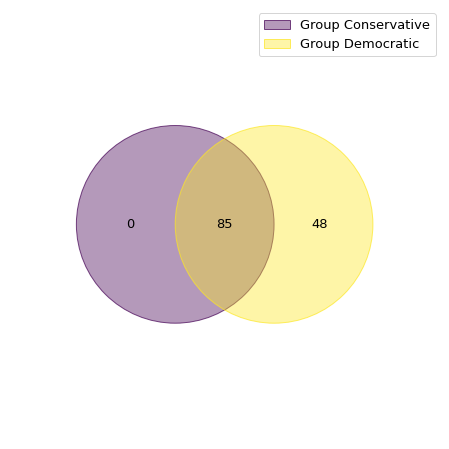

In [ ]:
from train import evaluate_model
from model import get_tokenizer
def convert_group_users_subreddit_submissions_data(group_x, users_in_group:dict, unique_submissions:dict):
    group_x_users_subreddit_submissions_data = []
    group_x_users = users_in_group[group_x]
    for user in group_x_users:
        for submission_id in unique_submissions:
            submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
            submission["USERNAME"] = user
            group_x_users_subreddit_submissions_data.append(submission)
    group_x_users_subreddit_submissions_data = pd.DataFrame(group_x_users_subreddit_submissions_data)
    return group_x_users_subreddit_submissions_data

def predict_group_users_preferred_submissions(model, group_x_users_subreddit_submissions_data:pd.DataFrame, train_data:pd.DataFrame, feature_names, existing_votes, thres = 0.9):

    # predict unseen votes
    group_x_users_subreddit_submissions_input = {name:group_x_users_subreddit_submissions_data[name] for name in feature_names if name in group_x_users_subreddit_submissions_data}
    # predict_group_x_users_subreddit_submissions_votes = model.predict(group_x_users_subreddit_submissions_input, batch_size=config['batch_size'])
    tokenizer = get_tokenizer(config)
    tokenized_submission_text = tokenizer(list(group_x_users_subreddit_submissions_data["SUBMISSION_TEXT"]), padding=True, truncation=True, max_length=512, return_tensors="pt")
    predict_group_x_users_subreddit_submissions_votes = evaluate_model(model, group_x_users_subreddit_submissions_input, tokenized_submission_text["input_ids"], tokenized_submission_text["token_type_ids"] if "token_type_ids" in tokenized_submission_text else None, tokenized_submission_text["attention_mask"], np.zeros([tokenized_submission_text["input_ids"].shape[0],1]), data=None, weights = None, batch_size=config["batch_size"], sample_voted_users=False, max_voted_users=max_voted_users, return_prediction = True)
    debug(predict_group_x_users_subreddit_submissions_votes=predict_group_x_users_subreddit_submissions_votes)
    submission_votes = {}
    user_confidence = defaultdict(list)
    for row_i, vote in enumerate(predict_group_x_users_subreddit_submissions_votes[:, 0]):
        row = group_x_users_subreddit_submissions_data.iloc[row_i]
        submission_id = row["SUBMISSION_ID"]
        if submission_id not in submission_votes:
            submission_votes[submission_id] = [0, 0]
        user_confidence[row["USERNAME"]].append(abs(vote - 0.5))
        if f'{row["USERNAME"]}-{row["SUBMISSION_ID"]}' not in existing_votes:
            vote = int(vote >= 0.5)
        else: # use existing votes if available
            vote = existing_votes[f'{row["USERNAME"]}-{row["SUBMISSION_ID"]}']
        submission_votes[submission_id][vote] += 1

    # analyze user confidence
    for username in user_confidence:
        user_confidence[username] = float(np.mean(user_confidence[username]))

    # include submissions to preferred_submissions where %upvotes is higher than threshold
    preferred_submissions = set()
    for submission_id in submission_votes:
        submission_votes[submission_id].append(submission_votes[submission_id][1] / (submission_votes[submission_id][0] + submission_votes[submission_id][1])) # %upvotes
        if submission_votes[submission_id][-1] >= thres:
            preferred_submissions.add(submission_id)

    # sort submissions using %upvotes
    submissions_ranking = list(submission_votes.keys())
    submissions_ranking.sort(reverse=True, key=lambda id: submission_votes[id][-1])
    return preferred_submissions, submissions_ranking, submission_votes, user_confidence


def predict_groups_preferences(users_in_groups, unique_submissions, train_data, feature_names, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes=None):
    
    # users_in_groups = existing_user_votes.most_common(3)

    groups_users_preferred_submissions = {}
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if (user_grouping_method == "rep") and (len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"] or len(users_in_groups[group_x]) > config["group_user_num_upper_thres"]): # keep middle sized centers
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if torch.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                continue
        group_x_users_subreddit_submissions_data = convert_group_users_subreddit_submissions_data(group_x, users_in_groups, unique_submissions)
        group_x_users_preferred_submissions, group_x_preferred_submissions_ranking, group_x_users_submission_votes, group_x_users_confidence = predict_group_users_preferred_submissions(model, group_x_users_subreddit_submissions_data, train_data, feature_names, existing_votes, thres = config["upvote_downvote_ratio_thres"])
        groups_users_preferred_submissions[f"Group {group_x}"] = group_x_users_preferred_submissions
        if user_grouping_method == "single_user_as_group":
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_users_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_users_preferred_submissions)}/{len(unique_submissions)} submissions (sorted using %upvotes): {group_x_preferred_submissions_ranking[:len(group_x_users_preferred_submissions)]}")
        if len(groups_users_preferred_submissions) > 1 and len(groups_users_preferred_submissions) <=6:
            ax = venn(groups_users_preferred_submissions) if len(groups_users_preferred_submissions) <=5 else pseudovenn(groups_users_preferred_submissions)
            ax.figure.savefig(f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_users_preferred_submissions)}_groups.png")


model = model.to(model.device)
predict_groups_preferences(users_in_groups, subreddit_test_submissions[a_subreddit], train_data, feature_names, group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes)
